In [ ]:
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("exploitation-pipeline").getOrCreate()
income      = spark.read.parquet("formatted_zone/income")      
population  = spark.read.parquet("formatted_zone/population_by_geographical")
incidences  = spark.read.parquet("formatted_zone/incidences")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/22 14:52:16 WARN Utils: Your hostname, MacBook-Air-de-Pol.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.62 instead (on interface en0)
25/06/22 14:52:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/22 14:52:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
income.printSchema()
population.printSchema()
incidences.printSchema()

root
 |-- Any: integer (nullable = true)
 |-- Codi_Districte: integer (nullable = true)
 |-- Nom_Districte: string (nullable = true)
 |-- Codi_Barri: integer (nullable = true)
 |-- Nom_Barri: string (nullable = true)
 |-- Població: integer (nullable = true)
 |-- Índex RFD Barcelona = 100: double (nullable = true)

root
 |-- Codi_Barri: long (nullable = true)
 |-- Codi_Districte: long (nullable = true)
 |-- Nom_Barri: string (nullable = true)
 |-- Nom_Districte: string (nullable = true)
 |-- Valor_int: integer (nullable = true)
 |-- Any: integer (nullable = true)
 |-- SEXE_desc: string (nullable = true)
 |-- NACIONALITAT_REGIO_desc: string (nullable = true)

root
 |-- Codi_Districte: integer (nullable = true)
 |-- DISTRICTE: string (nullable = true)
 |-- ANY_DATA_TANCAMENT: integer (nullable = true)
 |-- DETALL: string (nullable = true)
 |-- BARRI: string (nullable = true)
 |-- FITXA_ID: integer (nullable = true)
 |-- LATITUD: double (nullable = true)
 |-- AREA: string (nullable = true)

In [4]:
population.show(10)

+----------+--------------+---------+-------------+---------+----+---------+-----------------------+
|Codi_Barri|Codi_Districte|Nom_Barri|Nom_Districte|Valor_int| Any|SEXE_desc|NACIONALITAT_REGIO_desc|
+----------+--------------+---------+-------------+---------+----+---------+-----------------------+
|         1|             1| el Raval| Ciutat Vella|        7|2017|     Male|         Eastern Africa|
|         1|             1| el Raval| Ciutat Vella|        9|2017|   Female|          Middle Africa|
|         1|             1| el Raval| Ciutat Vella|       16|2017|     Male|          Middle Africa|
|         1|             1| el Raval| Ciutat Vella|      636|2017|   Female|        Northern Africa|
|         1|             1| el Raval| Ciutat Vella|      934|2017|     Male|        Northern Africa|
|         1|             1| el Raval| Ciutat Vella|        8|2017|     Male|        Southern Africa|
|         1|             1| el Raval| Ciutat Vella|       63|2017|   Female|         Wester

### Multiculutral index

We are going to create the **Shannon Diversity Index**, a measure of biodiversity that considers both the number of species (richness) and their relative abundance (evenness) within a community. A higher Shannon index generally indicates a more diverse and balanced community, while a lower index suggests a less diverse community, potentially dominated by one or a few species.

In this project, we apply this concept to human populations, using the diversity of nationalities present in a given region. While the Shannon Index is typically used to measure species evenness in ecological communities, we found it an interesting approach to use it for analyzing human diversity — since, biologically, humans are part of the animal kingdom.

**Note:**
Melissa and Pol — we are completely against any form of racism or discrimination. This project and its analysis are purely observational and neutral. There is no judgment of "good" or "bad" in this context. We simply thought it would be insightful to apply the Shannon Diversity Index to the datasets provided in class.

We calculate the diversity index of each neighborhood (barri) by treating each "NACIONALITAT_REGIO_desc" as a distinct "species" for the purpose of the calculation. However, we are fully aware that all humans are equal — we are all part of the same species. We hope this project is not misunderstood, and that its purpose and objectives are seen clearly as an exploration of data, not a commentary on value or worth.

$H=−∑p_i⋅log(p_i)$ 

Where $p_i$ is the proportion of people of a nationality in neighborhood.

In [5]:
""" Fist we calculate the tot_nac that is the total population by region and year. Then we calculate the tot_barri that is the total population by neighborhood and year.
Finally, we join both DataFrames to calculate p_i = total_regio / total_barri
Then we calculate the Shannon index for each neighborhood and year using the formula H = -sum(p_i * log(p_i))."""


tot_nac = (population
           .groupBy("Codi_Barri", "Any", "NACIONALITAT_REGIO_desc")
           .agg(F.sum("Valor_int").alias("total_regio")))

tot_barri = (population
             .groupBy("Codi_Barri", "Any")
             .agg(F.sum("Valor_int").alias("total_barri")))

# Join both dattasets with a inner joint  p_i = total_regio / total_barri
joined = (tot_nac
          .join(tot_barri, on=["Codi_Barri", "Any"], how="inner")
          .withColumn("p_i", F.col("total_regio") / F.col("total_barri")))

# H = -sum(p_i * log(p_i)) 
joined = joined.withColumn("p_logp", -F.col("p_i") * F.log(F.col("p_i")))
shannon_index = (joined
                 .groupBy("Codi_Barri", "Any")
                 .agg(F.sum("p_logp").alias("shannon_index")))


In [6]:
shannon_index.show(10)

+----------+----+-------------------+
|Codi_Barri| Any|      shannon_index|
+----------+----+-------------------+
|        66|2015| 0.8195131001523092|
|        53|2017| 0.8576459892264667|
|        49|2016|0.22710819806587076|
|         8|2017| 0.8486607090745553|
|        26|2017| 0.5619825409759708|
|        59|2015| 0.6090961171736372|
|        35|2015|  0.599295915418792|
|        35|2017| 0.6305465261147577|
|        56|2017| 0.5511675289616293|
|        71|2015|  0.585174532553239|
+----------+----+-------------------+
only showing top 10 rows


The advantage of using the Shannon Diversity Index is that it not only counts how many different nationalities are present, but also considers how evenly they are distributed within the same region. For example, if a neighborhood has 10 different nationalities but one of them makes up 90% of the population, it will have a lower index than another neighborhood where all nationalities are more evenly distributed.

In [ ]:
#multi = (tot_nac.filter("total_regio > 0").groupBy("Codi_Barri").agg(F.countDistinct("NACIONALITAT_REGIO_desc").alias("multicultural_idx")))

In [8]:
# i will save partitioned by year, but this should be in the formatted_zone
shannon_index.write \
    .option("header", True) \
    .partitionBy("Any") \
    .mode("overwrite") \
    .csv("exploitation_zone/shannon_index")

In [7]:
tot_nac.show(100)

+----------+----+-----------------------+-----------+
|Codi_Barri| Any|NACIONALITAT_REGIO_desc|total_regio|
+----------+----+-----------------------+-----------+
|         2|2017|        Northern Africa|        415|
|        17|2017|        Northern Europe|         84|
|        25|2017|           Eastern Asia|        214|
|        25|2017|         Eastern Europe|        333|
|        27|2017|           Western Asia|         55|
|        30|2017|         Western Africa|         24|
|        33|2017|        Northern Europe|        147|
|        41|2017|        Northern Africa|         13|
|        53|2017|           Western Asia|        136|
|         6|2017|          South America|       2785|
|         9|2017|          Middle Africa|         18|
|        32|2017|        Central America|        249|
|        35|2017|         Eastern Africa|          6|
|        38|2017|        Southern Europe|      10189|
|        10|2017|         Western Europe|        885|
|        14|2017|        Cen

### Visual study using geojson
we use from the landing_zone in the lookup_tables the "BarcelonaCiutat_Barris.csv" where we obtain the geographies of the neighborhoods that we can use to do a more visual analysis.

<Figure size 1200x800 with 0 Axes>

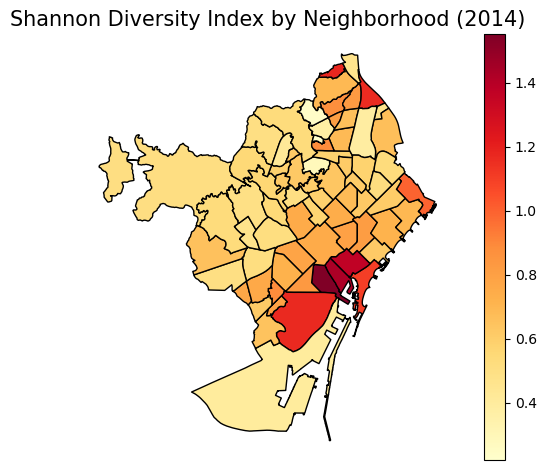

<Figure size 1200x800 with 0 Axes>

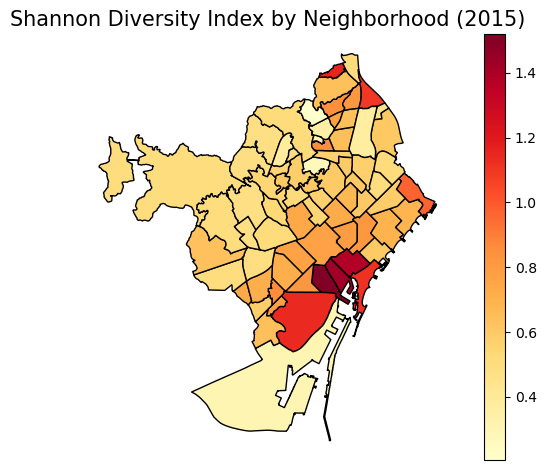

<Figure size 1200x800 with 0 Axes>

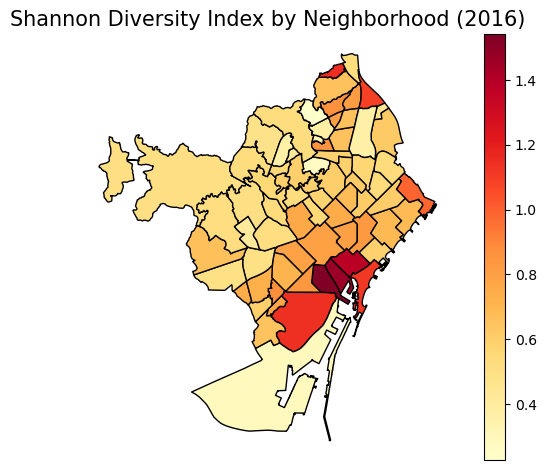

<Figure size 1200x800 with 0 Axes>

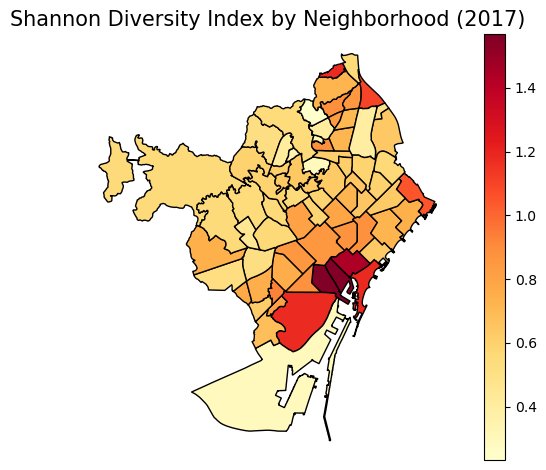

In [27]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt

barrios = pd.read_csv("landing_zone/lookup_tables/BarcelonaCiutat_Barris.csv")
barrios["geometry"] = barrios["geometria_wgs84"].apply(wkt.loads)
barrios_gdf = gpd.GeoDataFrame(barrios, geometry="geometry", crs="EPSG:4326")

barrios_gdf["codi_barri"] = barrios_gdf["codi_barri"].astype(str)
shannon_files =["exploitation_zone/shannon_index/Any=2014/part-00000-9edd2dda-2e43-4a06-a91e-b20f97de9549.c000.csv",
         "exploitation_zone/shannon_index/Any=2015/part-00000-9edd2dda-2e43-4a06-a91e-b20f97de9549.c000.csv",
         "exploitation_zone/shannon_index/Any=2016/part-00000-9edd2dda-2e43-4a06-a91e-b20f97de9549.c000.csv",
         "exploitation_zone/shannon_index/Any=2017/part-00000-9edd2dda-2e43-4a06-a91e-b20f97de9549.c000.csv"]

for file_path in shannon_files:
    year = file_path.split("Any=")[-1].split("/")[0]  # Extract year from path
    shannon_df = pd.read_csv(file_path)
    shannon_df["Codi_Barri"] = shannon_df["Codi_Barri"].astype(str)

    # Merge geometries with index data
    merged = barrios_gdf.merge(shannon_df, left_on="codi_barri", right_on="Codi_Barri")

    # Plot
    plt.figure(figsize=(12, 8))
    merged.plot(column="shannon_index", cmap="YlOrRd", legend=True, edgecolor="black")
    plt.title(f"Shannon Diversity Index by Neighborhood ({year})", fontsize=15)
    plt.axis("off")
    plt.tight_layout()
    plt.show()





In [24]:
merged

,codi_districte,nom_districte,codi_barri,nom_barri,geometria_etrs89,geometria_wgs84,geometry,Codi_Barri,shannon_index
0,1,Ciutat Vella,1,el Raval,"POLYGON ((430164.372950341 4581940.39758424, 4...","POLYGON ((2.16473952857229 41.3859611263672, 2...","POLYGON ((2.16474 41.38596, 2.16404 41.38543, ...",1,1.551340
1,1,Ciutat Vella,2,el Barri Gòtic,"POLYGON ((431192.082442968 4581854.86907373, 4...","POLYGON ((2.17703981017875 41.3852793578426, 2...","POLYGON ((2.17704 41.38528, 2.17661 41.38561, ...",2,1.427430
2,1,Ciutat Vella,3,la Barceloneta,"POLYGON ((432800.888667699 4582084.69046333, 4...","POLYGON ((2.1962542114702 41.3874852975771, 2....","POLYGON ((2.19625 41.38749, 2.1962 41.38749, 2...",3,1.101883
3,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera","POLYGON ((431735.899600634 4582445.23444175, 4...","POLYGON ((2.18347683856251 41.390642940051, 2....","POLYGON ((2.18348 41.39064, 2.18241 41.39145, ...",4,1.371907
4,2,Eixample,5,el Fort Pienc,"POLYGON ((431743.977580732 4582629.06573617, 4...","POLYGON ((2.18355273505655 41.3922993404645, 2...","POLYGON ((2.18355 41.3923, 2.18676 41.39467, 2...",5,0.797741
...,...,...,...,...,...,...,...,...,...
68,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,"POLYGON ((434228.873282652 4584678.5490042, 43...","POLYGON ((2.21305050684114 41.4109655883131, 2...","POLYGON ((2.21305 41.41097, 2.21192 41.41183, ...",69,0.697059
69,10,Sant Martí,70,el Besòs i el Maresme,"POLYGON ((434093.743891643 4585871.79499967, 4...","POLYGON ((2.21130382869618 41.4217017644346, 2...","POLYGON ((2.2113 41.4217, 2.20878 41.41981, 2....",70,0.995715
70,10,Sant Martí,71,Provençals del Poblenou,"POLYGON ((432760.615644181 4584099.69680979, 4...","POLYGON ((2.19554880988141 41.4056305449051, 2...","POLYGON ((2.19555 41.40563, 2.19884 41.40646, ...",71,0.608212
71,10,Sant Martí,72,Sant Martí de Provençals,"POLYGON ((432902.229521415 4584707.96513488, 4...","POLYGON ((2.19717547409715 41.4111208750969, 2...","POLYGON ((2.19718 41.41112, 2.19837 41.41202, ...",72,0.520364
